In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install category-encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.0 MB/s eta 0:00:00


In [ ]:
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from category_encoders import TargetEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.fft import fft
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/H4TF - Business 2/100000 Sales Records.csv')

In [ ]:
data['Order Date'] = pd.to_datetime(data['Order Date'], format='%m/%d/%Y')
data['Ship Date'] = pd.to_datetime(data['Ship Date'], format='%m/%d/%Y')
data = data.sort_values(by='Order Date').reset_index(drop=True)

In [ ]:
def create_features(data):
    data['Order Year'] = data['Order Date'].dt.year
    data['Order Month'] = data['Order Date'].dt.month
    data['Order Day'] = data['Order Date'].dt.day

    data['Ship Year'] = data['Ship Date'].dt.year
    data['Ship Month'] = data['Ship Date'].dt.month
    data['Ship Day'] = data['Ship Date'].dt.day

    data['Shipping Time'] = (data['Ship Date'] - data['Order Date']).dt.days
    data['On Time Delivery'] = np.where(data['Shipping Time'] <= 4, 1, 0)
    data['Order DayOfWeek'] = data['Order Date'].dt.dayofweek
    data['Ship DayOfWeek'] = data['Ship Date'].dt.dayofweek
    return data

data = create_features(data)

In [ ]:
daily_revenue = data.groupby(['Order Date'])['Total Revenue'].sum().reset_index()
daily_revenue.columns = ['Order Date', 'Daily Total Revenue']

daily_order_count = data.groupby(['Order Date'])['Order ID'].count().reset_index()
daily_order_count.columns = ['Order Date', 'Daily Order Count']

daily_units_sold = data.groupby(['Order Date'])['Units Sold'].sum().reset_index()
daily_units_sold.columns = ['Order Date', 'Daily Units Sold']

daily_avg_price = data.groupby(['Order Date'])['Unit Price'].mean().reset_index()
daily_avg_price.columns = ['Order Date', 'Daily Avg Price']


In [ ]:
daily_shipping_time = data.groupby(['Order Date'])['Shipping Time'].mean().reset_index()
daily_shipping_time.columns = ['Order Date', 'Average Shipping Time']

daily_on_time_delivery = data.groupby(['Order Date'])['On Time Delivery'].mean().reset_index()
daily_on_time_delivery.columns = ['Order Date', 'On Time Delivery Rate']

In [ ]:
# Gộp các đặc trưng tổng hợp vào dataframe chính
daily_data = daily_revenue
daily_data = daily_data.merge(daily_order_count, on='Order Date')
daily_data = daily_data.merge(daily_units_sold, on='Order Date')
daily_data = daily_data.merge(daily_avg_price, on='Order Date')
daily_data = daily_data.merge(daily_shipping_time, on='Order Date')
daily_data = daily_data.merge(daily_on_time_delivery, on='Order Date')

In [ ]:
# Đếm số lượng đơn hàng mỗi ngày theo từng giá trị của các biến phân loại
region_count = data.groupby(['Order Date', 'Region'])['Order ID'].count().unstack().fillna(0).reset_index()
region_count.columns = ['Order Date'] + [f'Count_{col}' for col in region_count.columns[1:]]

country_count = data.groupby(['Order Date', 'Country'])['Order ID'].count().unstack().fillna(0).reset_index()
country_count.columns = ['Order Date'] + [f'Count_{col}' for col in country_count.columns[1:]]

item_type_count = data.groupby(['Order Date', 'Item Type'])['Order ID'].count().unstack().fillna(0).reset_index()
item_type_count.columns = ['Order Date'] + [f'Count_{col}' for col in item_type_count.columns[1:]]

sales_channel_count = data.groupby(['Order Date', 'Sales Channel'])['Order ID'].count().unstack().fillna(0).reset_index()
sales_channel_count.columns = ['Order Date'] + [f'Count_{col}' for col in sales_channel_count.columns[1:]]

order_priority_count = data.groupby(['Order Date', 'Order Priority'])['Order ID'].count().unstack().fillna(0).reset_index()
order_priority_count.columns = ['Order Date'] + [f'Count_{col}' for col in order_priority_count.columns[1:]]

# Tổng doanh thu mỗi ngày theo từng giá trị của các biến phân loại
region_revenue = data.groupby(['Order Date', 'Region'])['Total Revenue'].sum().unstack().fillna(0).reset_index()
region_revenue.columns = ['Order Date'] + [f'Revenue_{col}' for col in region_revenue.columns[1:]]

country_revenue = data.groupby(['Order Date', 'Country'])['Total Revenue'].sum().unstack().fillna(0).reset_index()
country_revenue.columns = ['Order Date'] + [f'Revenue_{col}' for col in country_revenue.columns[1:]]

item_type_revenue = data.groupby(['Order Date', 'Item Type'])['Total Revenue'].sum().unstack().fillna(0).reset_index()
item_type_revenue.columns = ['Order Date'] + [f'Revenue_{col}' for col in item_type_revenue.columns[1:]]

sales_channel_revenue = data.groupby(['Order Date', 'Sales Channel'])['Total Revenue'].sum().unstack().fillna(0).reset_index()
sales_channel_revenue.columns = ['Order Date'] + [f'Revenue_{col}' for col in sales_channel_revenue.columns[1:]]

order_priority_revenue = data.groupby(['Order Date', 'Order Priority'])['Total Revenue'].sum().unstack().fillna(0).reset_index()
order_priority_revenue.columns = ['Order Date'] + [f'Revenue_{col}' for col in order_priority_revenue.columns[1:]]


In [ ]:
daily_data = daily_data.merge(region_count, on='Order Date')
daily_data = daily_data.merge(country_count, on='Order Date')
daily_data = daily_data.merge(item_type_count, on='Order Date')
daily_data = daily_data.merge(sales_channel_count, on='Order Date')
daily_data = daily_data.merge(order_priority_count, on='Order Date')

daily_data = daily_data.merge(region_revenue, on='Order Date')
daily_data = daily_data.merge(country_revenue, on='Order Date')
daily_data = daily_data.merge(item_type_revenue, on='Order Date')
daily_data = daily_data.merge(sales_channel_revenue, on='Order Date')
daily_data = daily_data.merge(order_priority_revenue, on='Order Date')


In [ ]:
daily_data.set_index('Order Date', inplace=True)

In [ ]:
train_data = daily_data['2010-01-01':'2016-12-31']
test_data = daily_data['2017-01-01':'2017-12-31']

In [ ]:
feature_columns = train_data.columns.drop(['Daily Total Revenue'])
X_train = train_data[feature_columns]
y_train = train_data['Daily Total Revenue']
X_test = test_data[feature_columns]
y_test = test_data['Daily Total Revenue']

In [ ]:
lgb_param_grid = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 64],
    'max_depth': [-1, 10, 20]
}

In [ ]:
lgb_model = lgb.LGBMRegressor()

In [ ]:
lgb_grid_search = GridSearchCV(estimator=lgb_model, param_grid=lgb_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

In [ ]:
lgb_grid_search.fit(X_train, y_train.ravel())

best_params = lgb_grid_search.best_params_
print(f'Best parameters found: {best_params}')

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36973
[LightGBM] [Info] Number of data points in the train set: 2557, number of used features: 425
[LightGBM] [Info] Start training from score 48339403.162300
Best parameters found: {'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 1000, 'num_leaves': 31}


In [ ]:
best_lgb_model = lgb.LGBMRegressor(**best_params)
best_lgb_model.fit(X_train, y_train.ravel())

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36973
[LightGBM] [Info] Number of data points in the train set: 2557, number of used features: 425
[LightGBM] [Info] Start training from score 48339403.162300


LGBMRegressor(learning_rate=0.01, max_depth=20, n_estimators=1000)

In [ ]:
y_train_pred = best_lgb_model.predict(X_train)
y_test_pred = best_lgb_model.predict(X_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [ ]:
def evaluate_model(y_true_train, y_pred_train, y_true_test, y_pred_test):
    # Calculate evaluation metrics for training data
    train_mae = mean_absolute_error(y_true_train, y_pred_train)
    train_mse = mean_squared_error(y_true_train, y_pred_train)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(y_true_train, y_pred_train)

    # Calculate evaluation metrics for testing data
    test_mae = mean_absolute_error(y_true_test, y_pred_test)
    test_mse = mean_squared_error(y_true_test, y_pred_test)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_true_test, y_pred_test)

    # Print evaluation metrics
    print(f"Training Data: MAE: {train_mae}, MSE: {train_mse}, RMSE: {train_rmse}, R-squared: {train_r2}")
    print(f"Testing Data: MAE: {test_mae}, MSE: {test_mse}, RMSE: {test_rmse}, R-squared: {test_r2}")

    # Return metrics as a dictionary
    metrics_dict = {
        'train_mae': train_mae,
        'train_mse': train_mse,
        'train_rmse': train_rmse,
        'train_r2': train_r2,
        'test_mae': test_mae,
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_r2': test_r2
    }

    return metrics_dict

In [ ]:
evaluate_model(y_train, y_train_pred, y_test, y_test_pred)

Training Data: MAE: 230064.0196009258, MSE: 128874885637.92789, RMSE: 358991.48407438287, R-squared: 0.9990729915626062
Testing Data: MAE: 625135.4962690792, MSE: 698710940796.7052, RMSE: 835889.3113305763, R-squared: 0.9945594456947493


{'train_mae': 230064.0196009258,
 'train_mse': 128874885637.92789,
 'train_rmse': 358991.48407438287,
 'train_r2': 0.9990729915626062,
 'test_mae': 625135.4962690792,
 'test_mse': 698710940796.7052,
 'test_rmse': 835889.3113305763,
 'test_r2': 0.9945594456947493}

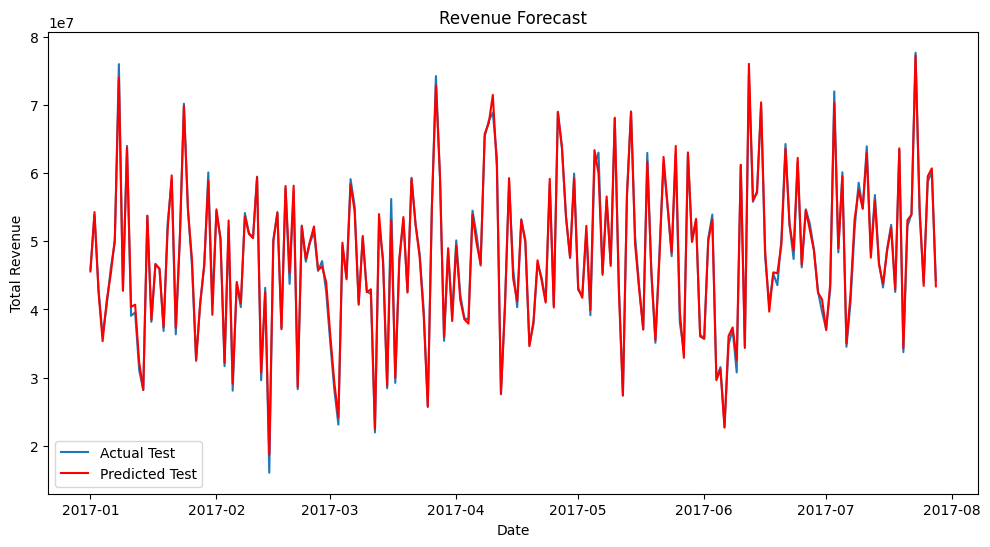

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(test_data.index, y_test, label='Actual Test')
plt.plot(test_data.index, y_test_pred, label='Predicted Test', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.title('Revenue Forecast')
plt.show()